## Relax Challenge

We are given two datasets:<br>

- takehome_users.csv: the user information for a certain product
- takehome_user_engagement.csv: usage summary information that has a row for each day that a user loggied into the product<br>

Define an 'adopted user' as a user who has logged into the product on three separate days in at least one seven-day period.  The goal for this notebook is to identify which factors predict future user adoption.

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("poster")

user_engagement = 'takehome_user_engagement.csv'
users = 'takehome_users.csv'

from datetime import datetime, date, timedelta
from collections import deque


In [178]:
df_engagement = pd.read_csv(user_engagement)
df_users = pd.read_csv(users)

In [179]:
print df_engagement.describe()
df_engagement.head(), df_engagement.dtypes

             user_id   visited
count  207917.000000  207917.0
mean     5913.314197       1.0
std      3394.941674       0.0
min         1.000000       1.0
25%      3087.000000       1.0
50%      5682.000000       1.0
75%      8944.000000       1.0
max     12000.000000       1.0


(            time_stamp  user_id  visited
 0  2014-04-22 03:53:30        1        1
 1  2013-11-15 03:45:04        2        1
 2  2013-11-29 03:45:04        2        1
 3  2013-12-09 03:45:04        2        1
 4  2013-12-25 03:45:04        2        1, time_stamp    object
 user_id        int64
 visited        int64
 dtype: object)

In [180]:
print df_users.describe()
print df_users.dtypes
df_users.head()

         object_id  last_session_creation_time  opted_in_to_mailing_list  \
count  12000.00000                8.823000e+03              12000.000000   
mean    6000.50000                1.379279e+09                  0.249500   
std     3464.24595                1.953116e+07                  0.432742   
min        1.00000                1.338452e+09                  0.000000   
25%     3000.75000                1.363195e+09                  0.000000   
50%     6000.50000                1.382888e+09                  0.000000   
75%     9000.25000                1.398443e+09                  0.000000   
max    12000.00000                1.402067e+09                  1.000000   

       enabled_for_marketing_drip        org_id  invited_by_user_id  
count                12000.000000  12000.000000         6417.000000  
mean                     0.149333    141.884583         5962.957145  
std                      0.356432    124.056723         3383.761968  
min                      0.000000  

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Cleaning Data

It was noticed that the time data are just strings, and it would be beneficial for us to cast this into datetime format in case we need to do some arithmetic with dates. There were two types of date encodings used, one was a plain string representation and the other was a unix timestamp representation.  We create functions to convert both into datetime objects and improve the dataframe. <br>

There were also categorical varaibles present, so we create dummy variables to encode these.

In [181]:
##make the creation_time and time_stamp into datetime objects for easier time manipulation

def make_datetime(value):
    return datetime.strptime(value, "%Y-%m-%d %H:%M:%S")

def from_unix_time(value):
    try:
        return datetime.fromtimestamp(int(value)).strftime('%Y-%m-%d %H:%M:%S')
    except:
        return pd.NaT

df_engagement['time_stamp'] = df_engagement['time_stamp'].apply(make_datetime)
df_users['creation_time'] = df_users['creation_time'].apply(make_datetime)
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].apply(from_unix_time)

In [182]:
#make dummy for categorical
df_users = pd.get_dummies(df_users, columns=['creation_source'])
df_users.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-21 20:53:30,1,0,11,10803.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-30 20:45:04,0,0,1,316.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 16:14:52,0,0,94,1525.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 01:09:28,0,0,1,5151.0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 02:14:20,0,0,193,5240.0,1,0,0,0,0


## Feature engineering

an adopted user is defined as a user who has logged into the product on three separate days in at least one seven-day period.  We create a function is_adopted_user to determine if a given user is adopted or not.<br>

The algorithm works as follows:<br>
1. split the dataframe into groups by userid
2. for each user id, get the times which they logged into the product.  This list of timestamps are filtered such that only the date is left, no duplicates exist, and sorted in ascending order.
3. the timestamps are then passed into a function is_adopted_user.  There is another variable called storage_queue. The purpose of this queue is to keep and update a list of dates which possibly fits into the adopted user condition.  If the length of this queue reaches 3, then we return True, indicating that the userid is an adopted user. If the storage_queue does not reach a length of 3, then we return False.<br>

Once we have a list of the adopted user_ids, we place these in the original dataframe as a new column


In [183]:
#go through the groups of user_id and check for adopted user condition
group_list = []
adopted_users = []


def is_adopted_user(dates, days_required=3):
    '''
    check if three separate logins happened in a seven day period
    '''
    storage_queue = deque()
    
    l_dates = list(dates)
    l_dates.sort()
    dates_queue = deque(l_dates)
    
    while dates_queue:
        date = dates_queue.popleft()
        
        if len(storage_queue)==0: #initial append
            storage_queue.append(date)
            continue
        
        storage_queue.append(date)
        #if difference between oldest date and current is > 7 days, pop oldest
        if date - storage_queue[0] > timedelta(days=7):
            _ = storage_queue.popleft()
        
        if len(storage_queue) >= days_required:
            return True
        
    return False



for group in df_engagement.groupby('user_id'):
    user_id = group[0]
    df = group[1]
    time_stamps = df['time_stamp'].apply(lambda x: x.date())
    if is_adopted_user(time_stamps):
        adopted_users.append(user_id)

    
print len(adopted_users)
    

1656


In [184]:
#we find 1656 user_ids who are adopted users, we add these to the data
#create a list of boolean to merge onto the dataframe
is_adopted = np.zeros(df_users.shape[0])
for index in adopted_users:
    is_adopted[index-1]=1
    
df_users_all = df_users.copy()
df_users_all.loc[:, 'is_adopted'] = is_adopted

## Corrleation check

For our information, we create a heatmap of correlations to see if certain variables has higher correlation to the target variable below.  We use the seaborn heatmap functionality and pandas pearson correlation function to achieve this.

In [185]:
#check columns and keep only the ones that adds values. ie, numerical values
print df_users_all.columns
df_users_all.dtypes

Index([u'object_id', u'creation_time', u'name', u'email',
       u'last_session_creation_time', u'opted_in_to_mailing_list',
       u'enabled_for_marketing_drip', u'org_id', u'invited_by_user_id',
       u'creation_source_GUEST_INVITE', u'creation_source_ORG_INVITE',
       u'creation_source_PERSONAL_PROJECTS', u'creation_source_SIGNUP',
       u'creation_source_SIGNUP_GOOGLE_AUTH', u'is_adopted'],
      dtype='object')


object_id                                      int64
creation_time                         datetime64[ns]
name                                          object
email                                         object
last_session_creation_time                    object
opted_in_to_mailing_list                       int64
enabled_for_marketing_drip                     int64
org_id                                         int64
invited_by_user_id                           float64
creation_source_GUEST_INVITE                   uint8
creation_source_ORG_INVITE                     uint8
creation_source_PERSONAL_PROJECTS              uint8
creation_source_SIGNUP                         uint8
creation_source_SIGNUP_GOOGLE_AUTH             uint8
is_adopted                                   float64
dtype: object

In [186]:
df_users_all.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-21 20:53:30,1,0,11,10803.0,1,0,0,0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-30 20:45:04,0,0,1,316.0,0,1,0,0,0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 16:14:52,0,0,94,1525.0,0,1,0,0,0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 01:09:28,0,0,1,5151.0,1,0,0,0,0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 02:14:20,0,0,193,5240.0,1,0,0,0,0,0.0


In [187]:
cols_whitelist = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip',\
                 'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',\
                 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', \
                 'creation_source_SIGNUP_GOOGLE_AUTH']
target = df_users_all['is_adopted']
inputs = df_users_all[cols_whitelist]

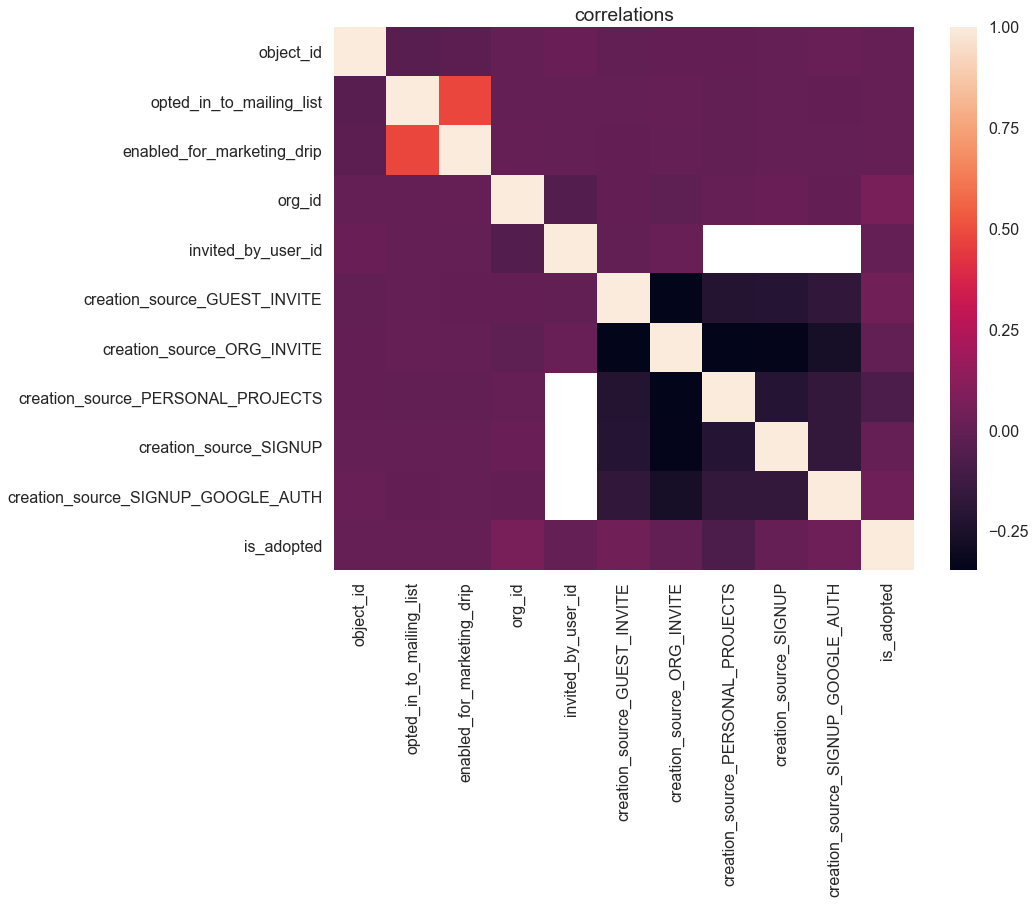

In [188]:
##check correlation
#we see pretty high correlation between opted_in_mailing_list and enabled_marketing_drip
plt.figure(figsize=(13,10))
corr = df_users_all.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
_ = plt.title('correlations')

## Further understanding of impacting variables

We utilize logistic regression to find which features has a higher impact to the outcome so specific suggestions can be made. We do this by fitting a regression to the data, and then checking the coefficients of the model.  Below, we find that users who have marketing_drip enabled and opted in to mailing_list has the highest impact to the dependent variable.  

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, target, test_size=0.3, random_state=42)

lr = LogisticRegression()
lr.fit(x_train,y_train)

print lr.score(x_train, y_train), lr.score(x_test, y_test)


0.862380952381 0.861111111111


In [190]:
col_coefficients = zip(lr.coef_[0], inputs.columns)
col_coefficients.sort()
col_coefficients

[(-0.90873281492008184, 'creation_source_PERSONAL_PROJECTS'),
 (-0.34596758508714925, 'creation_source_ORG_INVITE'),
 (-0.20985341525323978, 'creation_source_SIGNUP'),
 (-0.065705076424369832, 'creation_source_GUEST_INVITE'),
 (-0.039491133456989486, 'creation_source_SIGNUP_GOOGLE_AUTH'),
 (0.099144631682919537, 'opted_in_to_mailing_list'),
 (0.1088472338205947, 'enabled_for_marketing_drip')]

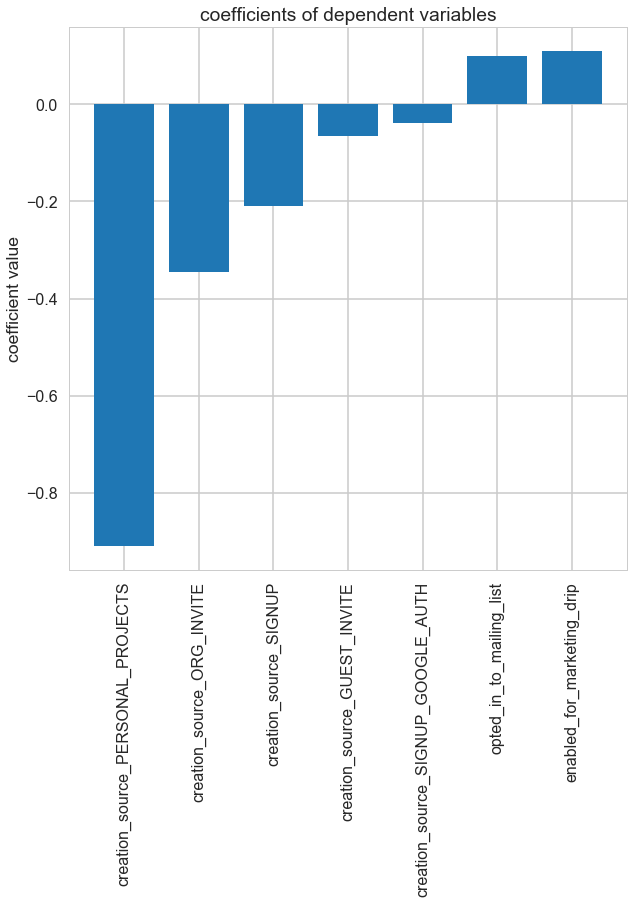

In [191]:
plt.figure(figsize=(10,10))
values = [i[0] for i in col_coefficients]
col_names = [i[1] for i in col_coefficients]
x_s = [i for i in range(len(col_names))]
plt.bar(x_s, values)
plt.xticks(x_s, col_names, rotation=90)
plt.title('coefficients of dependent variables')
plt.ylabel('coefficient value')
_ = plt.show()